In [1]:
import os
from typing import TypedDict, Annotated, Optional, Literal, Any
from IPython.display import display, Image

from pydantic import BaseModel
from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, END
from langgraph.graph import add_messages
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage
from langchain_core.prompts import ChatPromptTemplate

In [2]:
load_dotenv()

LITE_LLM_API_KEY = os.getenv("OPENAI_API_KEY")
LITE_LLM_URL = os.getenv("OPENAI_BASE_URL")
LITE_MODEL = os.getenv("OPENAI_MODEL")

In [3]:
model = ChatOpenAI(model=LITE_MODEL, api_key=LITE_LLM_API_KEY, base_url=LITE_LLM_URL)

In [4]:
class SpellcheckBase(BaseModel):
    spelling: str
    corrected_spelling: str
    correction_applied: bool


class ReasonerOutputBase(BaseModel):
    classification: str
    classification_explanation: str
    certainty_level: int

In [5]:
class ReasonerState(TypedDict):
    messages: Annotated[list, add_messages]
    spellcheck_response: Optional[SpellcheckBase]
    reasoner_response: Optional[ReasonerOutputBase]


class ClassifierState(TypedDict):
    msgs: Annotated[list, add_messages]
    finished_state: Optional[str]


classifier_builder = StateGraph(ClassifierState)


def reasoner(state: ClassifierState) -> ClassifierState:
    message = ChatPromptTemplate.from_messages(
        (
            "system",
            """Based on the user question you need to categorize into one of the following state of mind categories!
            Respond only with the category of the emotion!
            """,
        )
    )
    msg = message.format()
    model_structured = model.with_structured_output(ReasonerOutputBase)
    response = model_structured.invoke(state["msgs"] + [msg])
    return {"msgs": [AIMessage(response.classification)], "finished_state": None}


def reflect(state: ClassifierState) -> ClassifierState:
    input_val = state["msgs"][-2].content
    predicted_state = state["msgs"][-1].content
    prompt_template = ChatPromptTemplate.from_template(
        """
        You are a psychologist who get's a an users message and predicted emotional state of the individual.
        Your task is to lightly critique the prediction until you are satisfied that the
        correct emotional state is predicted!
        Be short with your explanations!
        If you agree with correct prediction respond with exactly "finish" without any explanations!
        Users message: {msg}
        Predicted emotional state: {state}
        """
    )
    prompt = prompt_template.invoke({"state": predicted_state, "msg": input_val})
    print("***prompt reasoner***", prompt)
    response = model.invoke(prompt)
    return {"msgs": [HumanMessage(response.content)], "finished_state": None}


def correct_found(state: ClassifierState) -> Literal["reasoner", "finish"]:
    if state["msgs"][-1].content == "finish":
        return "finish"
    return "reasoner"


def finish(state: ClassifierState) -> ClassifierState:
    finished_state = state["msgs"][-2].content
    return {"msgs": state["msgs"], "finished_state": finished_state}


classifier_builder.add_node("reasoner", reasoner)
classifier_builder.add_node("reflect", reflect)
classifier_builder.add_node("finish", finish)
classifier_builder.add_edge(START, "reasoner")
classifier_builder.add_edge("reasoner", "reflect")
classifier_builder.add_conditional_edges("reflect", correct_found)
classifier_builder.add_edge("reflect", END)

classify = classifier_builder.compile()


builder = StateGraph(ReasonerState)


def spellchecker(state: ReasonerState) -> ReasonerState:
    prompt_template = ChatPromptTemplate.from_template(
        """
        Spellcheck the users input. Do not explain yourself or add any other content!
        Respond only with the corrected full version of text. If no corrections have happened pass original text!

        Input: {input}
        """
    )
    model_structured = model.with_structured_output(SpellcheckBase)
    prompt = prompt_template.invoke({"input": state["messages"][0].content})
    response = model_structured.invoke(prompt)
    return {
        "messages": [],
        "spellcheck_response": response,
        "reasoner_response": None,
    }


def deeply_classify(state: ReasonerState) -> ReasonerState:
    msg = None
    for class_chunk in classify.stream(
        {"msgs": state["messages"], "finished_state": None}
    ):
        print("CLASSIFICATION CHUNK ->", class_chunk)
        if class_chunk["finished_state"] is not None:
            msg = class_chunk["finished_state"]

    return {
        "messages": [AIMessage(msg)],
        "spellcheck_response": state["spellcheck_response"],
        "reasoner_response": state["reasoner_response"],
    }


def reasoner(state: ReasonerState) -> ReasonerState:
    response = model.invoke(
        state["messages"]
        + [
            "Summarize the conversation and say the final emotional state. Do not explain yourself and prolong the conversation!"
        ]
    )
    return {
        "messages": [response.content],
        "spellcheck_response": state["spellcheck_response"],
        "reasoner_response": state["reasoner_response"],
    }

In [6]:
builder.add_node("spellchecker", spellchecker)
builder.add_node("deeply_classify", deeply_classify)
builder.add_node("reasoner", reasoner)
builder.add_edge(START, "spellchecker")
builder.add_edge("spellchecker", "deeply_classify")
builder.add_edge("deeply_classify", "reasoner")
builder.add_edge("reasoner", END)

In [7]:
graph = builder.compile()
for chunk in graph.stream({"messages": ["Jesus Christ!"]}):
    print(chunk)

{'spellchecker': {'messages': [], 'spellcheck_response': SpellcheckBase(spelling='Jesus Christ!', corrected_spelling='Jesus Christ!', correction_applied=False), 'reasoner_response': None}}
CLASSIFICATION CHUNK -> {'msgs': [HumanMessage(content='Jesus Christ!', additional_kwargs={}, response_metadata={}, id='34851992-a57b-4cfe-811f-f8113b632855')], 'finished_state': None}
CLASSIFICATION CHUNK -> {'msgs': [HumanMessage(content='Jesus Christ!', additional_kwargs={}, response_metadata={}, id='34851992-a57b-4cfe-811f-f8113b632855'), AIMessage(content='surprise', additional_kwargs={}, response_metadata={}, id='4e6fee4d-9b7a-47e5-a7c3-aa06066ab4cd')], 'finished_state': None}
***prompt reasoner*** messages=[HumanMessage(content='\n        You are a psychologist who get\'s a an users message and predicted emotional state of the individual.\n        Your task is to lightly critique the prediction until you are satisfied that the\n        correct emotional state is predicted!\n        Be short wi

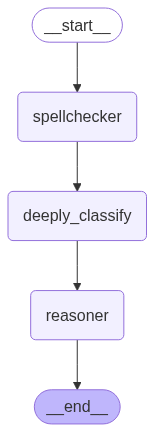

In [20]:
display(Image(graph.get_graph().draw_mermaid_png()))

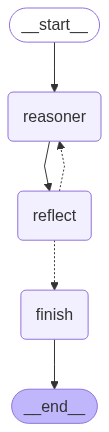

In [21]:
display(Image(classify.get_graph().draw_mermaid_png()))